<a href="https://colab.research.google.com/github/dimitarpg13/agentic_architectures_and_design_patterns/blob/main/notebooks/reinforcement_learning/multi_agent_colab/simulated_agentic_rl_workflow_with_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agentic Workflow with Reinforcement Learning Loop

This notebook demonstrates a sophisticated multi-agent system where agents learn optimal behaviors through reinforcement learning. The architecture combines:
- **Multi-Agent Coordination**: Agents with specialized roles
- **Reinforcement Learning**: PPO-based policy optimization
- **Tool Integration**: Agents can use external tools/APIs
- **Adaptive Workflow**: Learning-based task allocation
- **Production Patterns**: Monitoring, logging, and error handling

## 1. Environment Setup and Dependencies

In [1]:
# Install required packages
!pip install stable-baselines3 gymnasium numpy pandas matplotlib seaborn
!pip install langchain langchain-openai langgraph tensorboard
!pip install ray[rllib] wandb
!pip install mlflow pyngrok  # For exposing MLflow UI
!pip install mlflow[extras]  # Optional: additional integrations


  Using cached ormsgpack-1.12.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.2 kB)
Using cached ormsgpack-1.12.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (211 kB)
  Attempting uninstall: ormsgpack
    Found existing installation: ormsgpack 1.7.0
    Uninstalling ormsgpack-1.7.0:
      Successfully uninstalled ormsgpack-1.7.0
  Using cached ormsgpack-1.7.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (43 kB)
Using cached ormsgpack-1.7.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (220 kB)
  Attempting uninstall: ormsgpack
    Found existing installation: ormsgpack 1.12.1
    Uninstalling ormsgpack-1.12.1:
      Successfully uninstalled ormsgpack-1.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langgraph-checkpoint 3.0.1 requires ormsgpack>=1.12.0, but you have ormsgpack 1.7.0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Any, Union
from dataclasses import dataclass, field
from enum import Enum
import asyncio
import json
import logging
from datetime import datetime
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from collections import deque
import warnings
warnings.filterwarnings('ignore')

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## 2. Multi-Agent Environment Definition

Define a custom environment where multiple agents collaborate on tasks, learning optimal policies through RL.

In [3]:
class AgentRole(Enum):
    """Defines specialized agent roles in the system"""
    RESEARCHER = "researcher"
    ANALYZER = "analyzer"
    EXECUTOR = "executor"
    VALIDATOR = "validator"
    COORDINATOR = "coordinator"

@dataclass
class Task:
    """Represents a task in the workflow"""
    id: str
    type: str
    complexity: float
    requirements: List[str]
    deadline: float
    priority: float
    status: str = "pending"
    assigned_agent: Optional[str] = None
    completion_time: Optional[float] = None
    quality_score: Optional[float] = None

@dataclass
class AgentState:
    """Tracks individual agent state"""
    id: str
    role: AgentRole
    capacity: float
    expertise: Dict[str, float]
    current_load: float = 0.0
    completed_tasks: int = 0
    success_rate: float = 1.0
    collaboration_score: float = 1.0

In [4]:
class MultiAgentTaskEnvironment(gym.Env):
    """Multi-agent environment for collaborative task execution with RL"""

    def __init__(self, n_agents: int = 4, max_tasks: int = 10):
        super().__init__()
        self.n_agents = n_agents
        self.max_tasks = max_tasks
        self.current_step = 0
        self.max_steps = 200

        # Initialize agents with different roles
        self.agents = self._initialize_agents()

        # Task queue and completed tasks
        self.task_queue = deque()
        self.active_tasks = {}
        self.completed_tasks = []

        # Define observation and action spaces
        # Observation: [agent_states, task_queue_state, collaboration_matrix]
        obs_dim = n_agents * 7 + max_tasks * 5 + n_agents * n_agents
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32
        )

        # Action: [task_assignment, resource_allocation, collaboration_request]
        self.action_space = spaces.Box(
            low=0, high=1, shape=(n_agents * 3,), dtype=np.float32
        )

        # Metrics tracking
        self.episode_rewards = []
        self.task_completion_times = []
        self.collaboration_matrix = np.ones((n_agents, n_agents))

    def _initialize_agents(self) -> List[AgentState]:
        """Initialize agents with diverse roles and capabilities"""
        agents = []
        roles = list(AgentRole)[:self.n_agents]

        for i, role in enumerate(roles):
            expertise = {
                "research": np.random.uniform(0.5, 1.0),
                "analysis": np.random.uniform(0.5, 1.0),
                "execution": np.random.uniform(0.5, 1.0),
                "validation": np.random.uniform(0.5, 1.0)
            }

            # Boost expertise based on role
            if role == AgentRole.RESEARCHER:
                expertise["research"] = min(1.0, expertise["research"] + 0.3)
            elif role == AgentRole.ANALYZER:
                expertise["analysis"] = min(1.0, expertise["analysis"] + 0.3)

            agents.append(AgentState(
                id=f"agent_{i}",
                role=role,
                capacity=np.random.uniform(0.8, 1.0),
                expertise=expertise
            ))

        return agents

    def _generate_task(self) -> Task:
        """Generate a new task with random properties"""
        task_types = ["research", "analysis", "execution", "validation"]
        task_type = np.random.choice(task_types)

        return Task(
            id=f"task_{np.random.randint(10000)}",
            type=task_type,
            complexity=np.random.uniform(0.3, 1.0),
            requirements=[np.random.choice(task_types) for _ in range(np.random.randint(1, 3))],
            deadline=np.random.uniform(10, 50),
            priority=np.random.uniform(0.1, 1.0)
        )

    def _get_observation(self) -> np.ndarray:
        """Construct observation vector from current state"""
        obs = []

        # Agent states
        for agent in self.agents:
            obs.extend([
                agent.capacity,
                agent.current_load,
                agent.completed_tasks / max(1, self.current_step),
                agent.success_rate,
                agent.collaboration_score,
                agent.expertise.get("research", 0),
                agent.expertise.get("analysis", 0)
            ])

        # Task queue state
        for i in range(self.max_tasks):
            if i < len(self.task_queue):
                task = list(self.task_queue)[i]
                obs.extend([
                    task.complexity,
                    task.priority,
                    task.deadline,
                    1.0,  # task exists
                    0.0   # not yet assigned
                ])
            else:
                obs.extend([0, 0, 0, 0, 0])

        # Collaboration matrix (flattened)
        obs.extend(self.collaboration_matrix.flatten())

        return np.array(obs, dtype=np.float32)

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        """Execute action and return new state"""
        self.current_step += 1

        # Parse actions
        action = action.reshape(self.n_agents, 3)

        # Process task assignments
        reward = 0
        for i, agent in enumerate(self.agents):
            if len(self.task_queue) > 0 and action[i, 0] > 0.5:
                task = self.task_queue.popleft()
                self._assign_task(agent, task)

                # Calculate immediate reward for assignment
                match_score = agent.expertise.get(task.type, 0.5)
                reward += match_score * task.priority

        # Process active tasks
        completed_this_step = []
        for task_id, (task, agent) in list(self.active_tasks.items()):
            progress = agent.expertise.get(task.type, 0.5) * agent.capacity

            # Check if task completed
            if np.random.random() < progress:
                self._complete_task(task, agent)
                completed_this_step.append(task)

                # Calculate completion reward
                time_bonus = max(0, 1 - (self.current_step / task.deadline))
                quality = agent.expertise.get(task.type, 0.5) * agent.success_rate
                reward += (quality * task.priority * (1 + time_bonus)) * 10

        # Update collaboration matrix based on actions
        for i in range(self.n_agents):
            for j in range(self.n_agents):
                if i != j and action[i, 2] > 0.7 and action[j, 2] > 0.7:
                    self.collaboration_matrix[i, j] *= 1.01
                    reward += 0.5  # Collaboration bonus

        # Generate new tasks
        if np.random.random() < 0.3:
            self.task_queue.append(self._generate_task())

        # Calculate penalties
        queue_penalty = len(self.task_queue) * 0.1
        overdue_penalty = sum(1 for t in self.active_tasks.values()
                            if self.current_step > t[0].deadline) * 0.5
        reward -= (queue_penalty + overdue_penalty)

        # Check termination
        done = self.current_step >= self.max_steps
        truncated = False

        # Prepare info
        info = {
            "completed_tasks": len(completed_this_step),
            "queue_length": len(self.task_queue),
            "active_tasks": len(self.active_tasks),
            "avg_success_rate": np.mean([a.success_rate for a in self.agents])
        }

        return self._get_observation(), reward, done, truncated, info

    def _assign_task(self, agent: AgentState, task: Task):
        """Assign a task to an agent"""
        task.assigned_agent = agent.id
        task.status = "active"
        self.active_tasks[task.id] = (task, agent)
        agent.current_load += task.complexity

    def _complete_task(self, task: Task, agent: AgentState):
        """Mark a task as completed"""
        task.status = "completed"
        task.completion_time = self.current_step
        task.quality_score = agent.expertise.get(task.type, 0.5) * agent.success_rate

        self.completed_tasks.append(task)
        del self.active_tasks[task.id]

        agent.current_load = max(0, agent.current_load - task.complexity)
        agent.completed_tasks += 1
        agent.success_rate = 0.95 * agent.success_rate + 0.05 * task.quality_score

    def reset(self, seed=None, options=None) -> Tuple[np.ndarray, Dict]:
        """Reset environment to initial state"""
        super().reset(seed=seed)

        self.current_step = 0
        self.agents = self._initialize_agents()
        self.task_queue = deque([self._generate_task() for _ in range(3)])
        self.active_tasks = {}
        self.completed_tasks = []
        self.collaboration_matrix = np.ones((self.n_agents, self.n_agents))

        return self._get_observation(), {}

    def render(self):
        """Render current environment state"""
        print(f"\nStep: {self.current_step}")
        print(f"Tasks in queue: {len(self.task_queue)}")
        print(f"Active tasks: {len(self.active_tasks)}")
        print(f"Completed tasks: {len(self.completed_tasks)}")
        for agent in self.agents:
            print(f"  {agent.id} ({agent.role.value}): Load={agent.current_load:.2f}, "
                  f"Completed={agent.completed_tasks}, Success={agent.success_rate:.2f}")

## 3. Agentic Learning System with PPO

In [5]:
class AgenticRLSystem:
    """Orchestrates multi-agent reinforcement learning workflow"""

    def __init__(self, env_class, n_envs: int = 4):
        self.env_class = env_class
        self.n_envs = n_envs

        # Create vectorized environment for parallel training
        self.env = DummyVecEnv([lambda: env_class() for _ in range(n_envs)])
        self.eval_env = DummyVecEnv([lambda: env_class()])

        # Initialize PPO model with custom network architecture
        self.model = self._create_model()

        # Metrics tracking
        self.training_history = {
            "episode_rewards": [],
            "episode_lengths": [],
            "success_rates": [],
            "collaboration_scores": []
        }

        # Setup callbacks
        self.callbacks = self._setup_callbacks()

    def _create_model(self) -> PPO:
        """Create PPO model with custom architecture"""
        policy_kwargs = dict(
            net_arch=[
                dict(pi=[256, 256, 128], vf=[256, 256, 128])
            ],
            activation_fn=nn.ReLU
        )

        model = PPO(
            "MlpPolicy",
            self.env,
            learning_rate=3e-4,
            n_steps=2048,
            batch_size=64,
            n_epochs=10,
            gamma=0.99,
            gae_lambda=0.95,
            clip_range=0.2,
            clip_range_vf=None,
            ent_coef=0.01,
            vf_coef=0.5,
            max_grad_norm=0.5,
            policy_kwargs=policy_kwargs,
            verbose=1,
            tensorboard_log="./tensorboard_logs/"
        )

        return model

    def _setup_callbacks(self):
        """Setup training callbacks for monitoring and checkpointing"""
        eval_callback = EvalCallback(
            self.eval_env,
            best_model_save_path="./models/best_model/",
            log_path="./logs/",
            eval_freq=5000,
            deterministic=True,
            render=False,
            n_eval_episodes=10
        )

        checkpoint_callback = CheckpointCallback(
            save_freq=10000,
            save_path="./models/checkpoints/",
            name_prefix="agentic_rl_model"
        )

        return [eval_callback, checkpoint_callback]

    def train(self, total_timesteps: int = 100000):
        """Train the multi-agent system"""
        logger.info(f"Starting training for {total_timesteps} timesteps")

        self.model.learn(
            total_timesteps=total_timesteps,
            callback=self.callbacks,
            log_interval=10,
            progress_bar=True
        )

        logger.info("Training completed")
        return self.model

    def evaluate(self, n_episodes: int = 10) -> Dict[str, float]:
        """Evaluate the trained model"""
        env = self.env_class()

        episode_rewards = []
        episode_lengths = []
        task_completion_rates = []

        for episode in range(n_episodes):
            obs, _ = env.reset()
            done = False
            episode_reward = 0
            episode_length = 0

            while not done:
                action, _ = self.model.predict(obs, deterministic=True)
                obs, reward, done, truncated, info = env.step(action)
                episode_reward += reward
                episode_length += 1

            episode_rewards.append(episode_reward)
            episode_lengths.append(episode_length)

            if len(env.completed_tasks) > 0:
                completion_rate = len(env.completed_tasks) / (len(env.completed_tasks) + len(env.task_queue))
                task_completion_rates.append(completion_rate)

        metrics = {
            "mean_reward": np.mean(episode_rewards),
            "std_reward": np.std(episode_rewards),
            "mean_episode_length": np.mean(episode_lengths),
            "task_completion_rate": np.mean(task_completion_rates) if task_completion_rates else 0
        }

        return metrics

    def save_model(self, path: str):
        """Save the trained model"""
        self.model.save(path)
        logger.info(f"Model saved to {path}")

    def load_model(self, path: str):
        """Load a pre-trained model"""
        self.model = PPO.load(path, env=self.env)
        logger.info(f"Model loaded from {path}")

## 4. Advanced Agent Behaviors and Tool Integration

In [6]:
class ToolRegistry:
    """Registry for agent tools and capabilities"""

    def __init__(self):
        self.tools = {}
        self._register_default_tools()

    def _register_default_tools(self):
        """Register default tools available to agents"""
        self.register_tool(
            "web_search",
            self._mock_web_search,
            description="Search for information online",
            cost=0.1
        )
        self.register_tool(
            "data_analysis",
            self._mock_data_analysis,
            description="Analyze structured data",
            cost=0.2
        )
        self.register_tool(
            "code_generation",
            self._mock_code_generation,
            description="Generate code snippets",
            cost=0.3
        )

    def register_tool(self, name: str, func, description: str, cost: float):
        """Register a new tool"""
        self.tools[name] = {
            "function": func,
            "description": description,
            "cost": cost,
            "usage_count": 0
        }

    async def use_tool(self, tool_name: str, **kwargs) -> Dict[str, Any]:
        """Use a registered tool"""
        if tool_name not in self.tools:
            return {"error": f"Tool {tool_name} not found"}

        tool = self.tools[tool_name]
        tool["usage_count"] += 1

        try:
            result = await tool["function"](**kwargs)
            return {
                "success": True,
                "result": result,
                "cost": tool["cost"]
            }
        except Exception as e:
            return {
                "success": False,
                "error": str(e),
                "cost": tool["cost"]
            }

    async def _mock_web_search(self, query: str) -> str:
        """Mock web search tool"""
        await asyncio.sleep(0.1)  # Simulate API call
        return f"Search results for: {query}"

    async def _mock_data_analysis(self, data: Any) -> Dict:
        """Mock data analysis tool"""
        await asyncio.sleep(0.2)
        return {"insights": "Data patterns detected", "confidence": 0.85}

    async def _mock_code_generation(self, prompt: str) -> str:
        """Mock code generation tool"""
        await asyncio.sleep(0.3)
        return f"def generated_function():\n    # Code for: {prompt}\n    pass"

class SmartAgent:
    """Individual agent with learning capabilities and tool usage"""

    def __init__(self, agent_id: str, role: AgentRole, tool_registry: ToolRegistry):
        self.id = agent_id
        self.role = role
        self.tool_registry = tool_registry

        # Learning parameters
        self.q_table = {}  # Simple Q-learning for tool selection
        self.epsilon = 0.1  # Exploration rate
        self.learning_rate = 0.1
        self.discount_factor = 0.95

        # Performance tracking
        self.task_history = []
        self.tool_effectiveness = {tool: 1.0 for tool in tool_registry.tools}

    async def process_task(self, task: Task) -> Dict[str, Any]:
        """Process a task using available tools and learned strategies"""
        start_time = datetime.now()

        # Select tool based on Q-learning
        selected_tool = self._select_tool(task)

        # Use the selected tool
        tool_result = await self.tool_registry.use_tool(
            selected_tool,
            query=f"Process task: {task.type}"
        )

        # Calculate reward
        processing_time = (datetime.now() - start_time).total_seconds()
        reward = self._calculate_reward(tool_result, processing_time, task)

        # Update Q-table
        self._update_q_table(task.type, selected_tool, reward)

        # Record task completion
        self.task_history.append({
            "task_id": task.id,
            "tool_used": selected_tool,
            "reward": reward,
            "processing_time": processing_time
        })

        return {
            "agent_id": self.id,
            "task_id": task.id,
            "tool_used": selected_tool,
            "result": tool_result,
            "processing_time": processing_time,
            "reward": reward
        }

    def _select_tool(self, task: Task) -> str:
        """Select tool using epsilon-greedy strategy"""
        if np.random.random() < self.epsilon:
            # Explore: random tool selection
            return np.random.choice(list(self.tool_registry.tools.keys()))
        else:
            # Exploit: select best tool based on Q-values
            state = task.type
            if state not in self.q_table:
                self.q_table[state] = {tool: 0.0 for tool in self.tool_registry.tools}

            return max(self.q_table[state], key=self.q_table[state].get)

    def _calculate_reward(self, tool_result: Dict, processing_time: float, task: Task) -> float:
        """Calculate reward based on tool effectiveness and efficiency"""
        base_reward = 1.0 if tool_result.get("success", False) else -0.5
        time_penalty = -processing_time * 0.1
        cost_penalty = -tool_result.get("cost", 0) * 0.5
        priority_bonus = task.priority * 0.5

        return base_reward + time_penalty + cost_penalty + priority_bonus

    def _update_q_table(self, state: str, action: str, reward: float):
        """Update Q-table using Q-learning update rule"""
        if state not in self.q_table:
            self.q_table[state] = {tool: 0.0 for tool in self.tool_registry.tools}

        old_value = self.q_table[state][action]
        # Simplified update without next state (terminal state assumed)
        self.q_table[state][action] = old_value + self.learning_rate * (reward - old_value)

        # Update tool effectiveness tracking
        self.tool_effectiveness[action] = (
            0.95 * self.tool_effectiveness[action] + 0.05 * (reward > 0)
        )

## 5. Training and Evaluation Pipeline

In [7]:
def train_agentic_rl_system():
    """Main training pipeline for the agentic RL system"""

    # Initialize environment and system
    print("Initializing Agentic RL System...")
    system = AgenticRLSystem(MultiAgentTaskEnvironment, n_envs=4)

    # Training configuration
    training_config = {
        "total_timesteps": 50000,
        "eval_frequency": 5000,
        "n_eval_episodes": 10
    }

    print(f"\nStarting training with {training_config['total_timesteps']} timesteps...")

    # Train the system
    trained_model = system.train(total_timesteps=training_config['total_timesteps'])

    # Evaluate performance
    print("\nEvaluating trained model...")
    metrics = system.evaluate(n_episodes=training_config['n_eval_episodes'])

    print("\n" + "="*50)
    print("Training Complete - Performance Metrics:")
    print("="*50)
    for key, value in metrics.items():
        print(f"{key}: {value:.3f}")

    # Save the model
    system.save_model("./models/trained_agentic_rl_model")

    return system, metrics

# Train the system
# Uncomment to run training (will take some time)
# system, metrics = train_agentic_rl_system()

## 6. Advanced Monitoring and Visualization

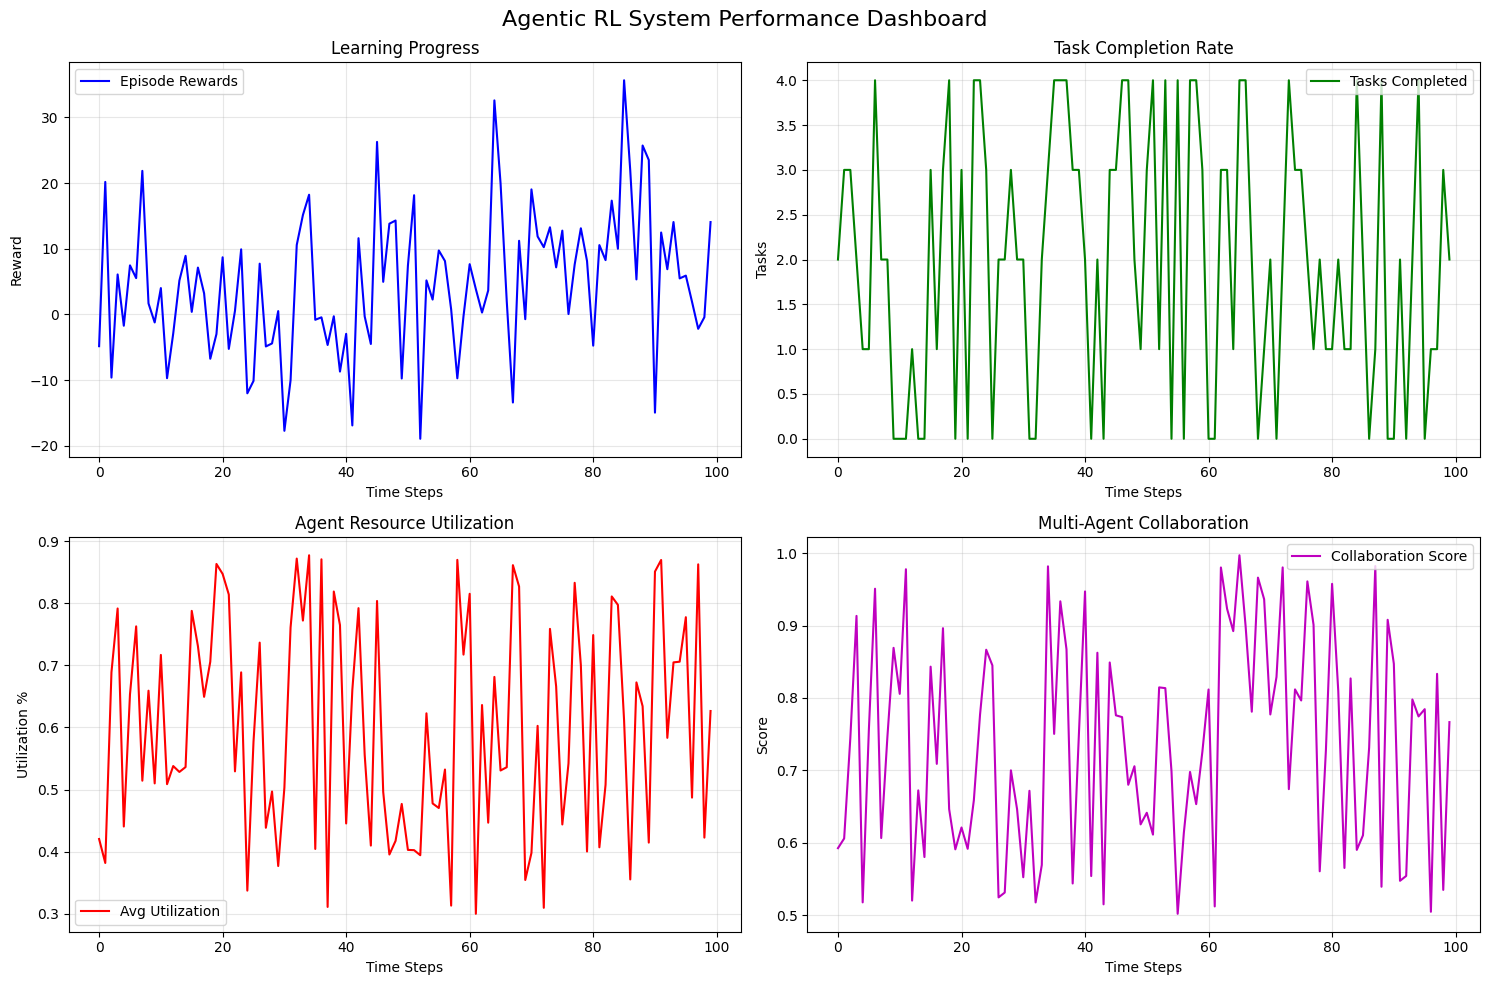


Performance Report:
                    Metric       Value
0            Total Rewards  469.991350
1      Avg Task Completion    1.970000
2         Peak Utilization    0.877211
3  Avg Collaboration Score    0.736848
4         Total Time Steps  100.000000


In [8]:
class PerformanceMonitor:
    """Monitor and visualize system performance"""

    def __init__(self):
        self.metrics_history = {
            "timestamps": [],
            "rewards": [],
            "task_completions": [],
            "agent_utilization": [],
            "collaboration_scores": [],
            "tool_usage": {}
        }

    def record_metrics(self, timestamp: float, env_info: Dict, agent_metrics: Dict):
        """Record performance metrics"""
        self.metrics_history["timestamps"].append(timestamp)
        self.metrics_history["rewards"].append(env_info.get("reward", 0))
        self.metrics_history["task_completions"].append(env_info.get("completed_tasks", 0))
        self.metrics_history["agent_utilization"].append(agent_metrics.get("avg_utilization", 0))
        self.metrics_history["collaboration_scores"].append(agent_metrics.get("collaboration_score", 0))

    def plot_performance(self):
        """Create performance visualization dashboard"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Agentic RL System Performance Dashboard", fontsize=16)

        # Plot 1: Rewards over time
        axes[0, 0].plot(self.metrics_history["timestamps"],
                       self.metrics_history["rewards"],
                       'b-', label='Episode Rewards')
        axes[0, 0].set_xlabel('Time Steps')
        axes[0, 0].set_ylabel('Reward')
        axes[0, 0].set_title('Learning Progress')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].legend()

        # Plot 2: Task completion rate
        axes[0, 1].plot(self.metrics_history["timestamps"],
                       self.metrics_history["task_completions"],
                       'g-', label='Tasks Completed')
        axes[0, 1].set_xlabel('Time Steps')
        axes[0, 1].set_ylabel('Tasks')
        axes[0, 1].set_title('Task Completion Rate')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].legend()

        # Plot 3: Agent utilization
        axes[1, 0].plot(self.metrics_history["timestamps"],
                       self.metrics_history["agent_utilization"],
                       'r-', label='Avg Utilization')
        axes[1, 0].set_xlabel('Time Steps')
        axes[1, 0].set_ylabel('Utilization %')
        axes[1, 0].set_title('Agent Resource Utilization')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].legend()

        # Plot 4: Collaboration scores
        axes[1, 1].plot(self.metrics_history["timestamps"],
                       self.metrics_history["collaboration_scores"],
                       'm-', label='Collaboration Score')
        axes[1, 1].set_xlabel('Time Steps')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].set_title('Multi-Agent Collaboration')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].legend()

        plt.tight_layout()
        plt.show()

    def generate_report(self) -> pd.DataFrame:
        """Generate performance report as DataFrame"""
        report_data = {
            'Metric': ['Total Rewards', 'Avg Task Completion', 'Peak Utilization',
                      'Avg Collaboration Score', 'Total Time Steps'],
            'Value': [
                np.sum(self.metrics_history["rewards"]),
                np.mean(self.metrics_history["task_completions"]),
                np.max(self.metrics_history["agent_utilization"]),
                np.mean(self.metrics_history["collaboration_scores"]),
                len(self.metrics_history["timestamps"])
            ]
        }

        return pd.DataFrame(report_data)

# Example usage
monitor = PerformanceMonitor()

# Simulate some metrics recording
for i in range(100):
    monitor.record_metrics(
        timestamp=i,
        env_info={"reward": np.random.randn() * 10 + i * 0.1, "completed_tasks": np.random.randint(0, 5)},
        agent_metrics={"avg_utilization": np.random.uniform(0.3, 0.9), "collaboration_score": np.random.uniform(0.5, 1.0)}
    )

# Visualize performance
monitor.plot_performance()

# Generate report
report = monitor.generate_report()
print("\nPerformance Report:")
print(report)

## 7. Production Deployment Considerations

In [9]:
class ProductionAgenticSystem:
    """Production-ready agentic RL system with monitoring and error handling"""

    def __init__(self, model_path: str, config: Dict[str, Any]):
        self.config = config
        self.model_path = model_path

        # Load trained model
        self.model = None  # Would load actual model here

        # Initialize components
        self.tool_registry = ToolRegistry()
        self.monitor = PerformanceMonitor()

        # Error handling and circuit breaker
        self.error_count = 0
        self.max_errors = config.get("max_errors", 10)
        self.circuit_breaker_open = False

        # Rate limiting
        self.request_times = deque(maxlen=100)
        self.max_requests_per_minute = config.get("max_rpm", 60)

    async def process_request(self, request: Dict[str, Any]) -> Dict[str, Any]:
        """Process incoming request with production safeguards"""

        # Check circuit breaker
        if self.circuit_breaker_open:
            return {"error": "Circuit breaker open - system temporarily unavailable"}

        # Rate limiting
        if not self._check_rate_limit():
            return {"error": "Rate limit exceeded"}

        try:
            # Validate request
            validation_result = self._validate_request(request)
            if not validation_result["valid"]:
                return {"error": validation_result["message"]}

            # Process with timeout
            result = await asyncio.wait_for(
                self._process_with_agents(request),
                timeout=self.config.get("timeout", 30)
            )

            # Reset error count on success
            self.error_count = 0

            # Record metrics
            self._record_metrics(result)

            return result

        except asyncio.TimeoutError:
            self._handle_error("Timeout")
            return {"error": "Request timeout"}

        except Exception as e:
            self._handle_error(str(e))
            return {"error": f"Processing error: {str(e)}"}

    def _check_rate_limit(self) -> bool:
        """Check if request is within rate limits"""
        current_time = datetime.now()
        self.request_times.append(current_time)

        # Count requests in last minute
        minute_ago = current_time.timestamp() - 60
        recent_requests = sum(1 for t in self.request_times
                            if t.timestamp() > minute_ago)

        return recent_requests < self.max_requests_per_minute

    def _validate_request(self, request: Dict) -> Dict[str, Any]:
        """Validate incoming request"""
        required_fields = ["task_type", "priority"]

        for field in required_fields:
            if field not in request:
                return {"valid": False, "message": f"Missing required field: {field}"}

        if request["priority"] < 0 or request["priority"] > 1:
            return {"valid": False, "message": "Priority must be between 0 and 1"}

        return {"valid": True}

    async def _process_with_agents(self, request: Dict) -> Dict[str, Any]:
        """Process request using trained agents"""
        # This would use the actual trained model and agents
        await asyncio.sleep(0.1)  # Simulate processing

        return {
            "status": "completed",
            "request_id": request.get("id", "unknown"),
            "result": "Processed successfully",
            "processing_time": 0.1,
            "agents_used": ["agent_0", "agent_1"]
        }

    def _handle_error(self, error_message: str):
        """Handle errors with circuit breaker pattern"""
        logger.error(f"Error occurred: {error_message}")
        self.error_count += 1

        if self.error_count >= self.max_errors:
            self.circuit_breaker_open = True
            logger.critical("Circuit breaker opened due to excessive errors")

            # Schedule circuit breaker reset
            asyncio.create_task(self._reset_circuit_breaker())

    async def _reset_circuit_breaker(self):
        """Reset circuit breaker after cooldown period"""
        await asyncio.sleep(self.config.get("circuit_breaker_cooldown", 60))
        self.circuit_breaker_open = False
        self.error_count = 0
        logger.info("Circuit breaker reset")

    def _record_metrics(self, result: Dict):
        """Record processing metrics"""
        # Would send to monitoring system (Prometheus, DataDog, etc.)
        pass

    def get_health_status(self) -> Dict[str, Any]:
        """Get system health status for monitoring"""
        return {
            "status": "unhealthy" if self.circuit_breaker_open else "healthy",
            "error_count": self.error_count,
            "circuit_breaker": "open" if self.circuit_breaker_open else "closed",
            "recent_requests": len(self.request_times),
            "timestamp": datetime.now().isoformat()
        }

# Example production configuration
production_config = {
    "max_errors": 10,
    "max_rpm": 60,
    "timeout": 30,
    "circuit_breaker_cooldown": 60,
    "model_path": "./models/trained_agentic_rl_model",
    "enable_monitoring": True,
    "log_level": "INFO"
}

# Initialize production system
prod_system = ProductionAgenticSystem("./models/model.pkl", production_config)

# Example health check
health_status = prod_system.get_health_status()
print("\nSystem Health Status:")
for key, value in health_status.items():
    print(f"  {key}: {value}")


System Health Status:
  status: healthy
  error_count: 0
  circuit_breaker: closed
  recent_requests: 0
  timestamp: 2026-01-11T06:58:22.314648


## 8. MLflow Integration for Experiment Tracking

8.1. MLflow setup for google colab

8.1.1 relevant imports

In [ ]:
import mlflow
import os
from pathlib import Path
import subprocess
import threading
import time

8.1.2. Google Drive Integration (Recommended for Persistence)

In [ ]:
from google.colab import drive

# Mount Google Drive for persistent storage
drive.mount('/content/drive')

# Set up MLflow tracking directory in Google Drive
MLFLOW_TRACKING_DIR = '/content/drive/MyDrive/mlflow_experiments'
Path(MLFLOW_TRACKING_DIR).mkdir(parents=True, exist_ok=True)

# Configure MLflow tracking URI
mlflow.set_tracking_uri(f'file://{MLFLOW_TRACKING_DIR}')
print(f"MLflow tracking URI set to: {mlflow.get_tracking_uri()}")

8.2 Production-Ready MLflow Configuration Class using NGrok by default

In [ ]:
import json
from datetime import datetime
from typing import Optional, Dict, Any
import pandas as pd

class ColabMLflowManager:
    """
    Complete MLflow manager for Google Colab environments
    """

    def __init__(
        self,
        experiment_name: str,
        use_drive: bool = True,
        drive_folder: str = 'mlflow_experiments',
        auto_start_ui: bool = True
    ):
        self.experiment_name = experiment_name
        self.use_drive = use_drive
        self.drive_folder = drive_folder
        self.mlflow_process = None
        self.public_url = None

        # Setup storage
        self._setup_storage()

        # Configure MLflow
        mlflow.set_tracking_uri(self.tracking_uri)

        # Create or get experiment
        self.experiment = mlflow.set_experiment(experiment_name)

        # Start UI if requested
        if auto_start_ui:
            self.start_ui()

    def _setup_storage(self):
        """Configure storage backend"""
        if self.use_drive:
            try:
                from google.colab import drive
                drive.mount('/content/drive', force_remount=False)
                self.base_path = f'/content/drive/MyDrive/{self.drive_folder}'
            except:
                print("⚠️ Google Drive mount failed, using local storage")
                self.base_path = f'/content/{self.drive_folder}'
        else:
            self.base_path = f'/content/{self.drive_folder}'

        # Create directory
        Path(self.base_path).mkdir(parents=True, exist_ok=True)
        self.tracking_uri = f'file://{self.base_path}'
        print(f"📁 MLflow storage: {self.base_path}")

    def start_ui(self, port: int = 5000, use_ngrok: bool = True):
        """Start MLflow UI with public access"""
        # Kill existing servers
        subprocess.run(["pkill", "-f", "mlflow.server"], capture_output=True)
        time.sleep(2)

        # Start MLflow server
        mlflow_cmd = [
            "mlflow", "server",
            "--backend-store-uri", self.tracking_uri,
            "--default-artifact-root", self.tracking_uri,
            "--host", "0.0.0.0",
            "--port", str(port),
            "--serve-artifacts"
        ]

        self.mlflow_process = subprocess.Popen(
            mlflow_cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )

        print("⏳ Starting MLflow server...")
        time.sleep(5)
        config = {
          "addr": port,  # Your local port
          "proto": "http",
          "host_header": f"localhost:{str(port)}"  # Custom host header
        }

        if use_ngrok:

            try:
                from pyngrok import ngrok
                auth_token = getpass.getpass()

                if auth_token:
                    ngrok.set_auth_token(auth_token)
                ngrok.kill()
                time.sleep(1)
                self.public_url = ngrok.connect(**config)
                print(f"\n✅ MLflow UI: {self.public_url}")
                print(f"📊 Experiment: {self.experiment_name}")
            except Exception as e:
                print(f"⚠️ Ngrok setup failed: {e}")
                self._try_localtunnel(port)
        else:
            self._try_localtunnel(port)

    def _try_localtunnel(self, port: int):
        """Fallback to localtunnel"""
        try:
            subprocess.run(["npm", "install", "-g", "localtunnel"],
                         capture_output=True, check=True)

            lt_process = subprocess.Popen(
                f"lt --port {port} --local-host localhost",
                shell=True,
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                text=True
            )

            for line in lt_process.stdout:
                if "your url is" in line.lower():
                    self.public_url = line.split("https://")[-1].strip()
                    print(f"\n✅ MLflow UI: https://{self.public_url}")
                    break
        except Exception as e:
            print(f"⚠️ Localtunnel failed: {e}")
            print(f"📍 MLflow running locally on port {port}")

    def log_metrics_batch(self, metrics: Dict[str, Any], step: int = 0):
        """Log multiple metrics at once"""
        for key, value in metrics.items():
            mlflow.log_metric(key, value, step=step)

    def log_params_batch(self, params: Dict[str, Any]):
        """Log multiple parameters at once"""
        for key, value in params.items():
            mlflow.log_param(key, value)

    def log_model_with_metadata(
        self,
        model,
        artifact_path: str,
        model_type: str = "sklearn",
        metadata: Optional[Dict] = None
    ):
        """Log model with comprehensive metadata"""
        # Log model
        if model_type == "sklearn":
            mlflow.sklearn.log_model(model, artifact_path)
        elif model_type == "pytorch":
            mlflow.pytorch.log_model(model, artifact_path)
        elif model_type == "tensorflow":
            mlflow.tensorflow.log_model(model, artifact_path)
        else:
            mlflow.pyfunc.log_model(artifact_path, python_model=model)

        # Log metadata
        if metadata:
            metadata['timestamp'] = datetime.now().isoformat()
            metadata['model_type'] = model_type

            with open('/tmp/model_metadata.json', 'w') as f:
                json.dump(metadata, f, indent=2)
            mlflow.log_artifact('/tmp/model_metadata.json')

    def cleanup(self):
        """Clean up resources"""
        if self.mlflow_process:
            self.mlflow_process.terminate()
            self.mlflow_process.wait()

        if self.public_url:
            try:
                from pyngrok import ngrok
                ngrok.kill()
            except:
                pass

    def get_experiment_info(self) -> pd.DataFrame:
        """Get experiment runs as DataFrame"""
        runs = mlflow.search_runs(
            experiment_ids=[self.experiment.experiment_id]
        )
        return runs

8.3 Run experiment and capture some log data using the class `ColabMLflowManager`

In [10]:
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

class MLflowExperimentTracker:
    """Track RL experiments with MLflow"""

    def __init__(self, experiment_name: str = "agentic_rl_workflow"):
        self.experiment_name = experiment_name
        mlflow.set_experiment(experiment_name)
        self.client = MlflowClient()

    def start_run(self, run_name: str, tags: Dict[str, str] = None):
        """Start a new MLflow run"""
        mlflow.start_run(run_name=run_name)

        if tags:
            for key, value in tags.items():
                mlflow.set_tag(key, value)

    def log_hyperparameters(self, params: Dict[str, Any]):
        """Log hyperparameters"""
        for key, value in params.items():
            mlflow.log_param(key, value)

    def log_metrics(self, metrics: Dict[str, float], step: int = None):
        """Log metrics"""
        for key, value in metrics.items():
            mlflow.log_metric(key, value, step=step)

    def log_model(self, model, model_name: str):
        """Log trained model"""
        mlflow.pytorch.log_model(model, model_name)

    def log_artifacts(self, artifact_path: str):
        """Log additional artifacts"""
        mlflow.log_artifacts(artifact_path)

    def end_run(self):
        """End the current MLflow run"""
        mlflow.end_run()

    def compare_runs(self, metric_name: str = "mean_reward") -> pd.DataFrame:
        """Compare different experiment runs"""
        experiment = self.client.get_experiment_by_name(self.experiment_name)
        runs = self.client.search_runs(
            experiment_ids=[experiment.experiment_id],
            order_by=[f"metrics.{metric_name} DESC"]
        )

        comparison_data = []
        for run in runs:
            comparison_data.append({
                "run_id": run.info.run_id,
                "run_name": run.info.run_name,
                metric_name: run.data.metrics.get(metric_name, None),
                "status": run.info.status
            })

        return pd.DataFrame(comparison_data)

# Example usage
tracker = MLflowExperimentTracker("agentic_rl_experiments")

# Simulate an experiment run
def run_tracked_experiment():
    # Start run
    tracker.start_run(
        run_name="ppo_multi_agent_v1",
        tags={"algorithm": "PPO", "environment": "MultiAgentTask", "version": "1.0"}
    )

    # Log hyperparameters
    hyperparams = {
        "learning_rate": 3e-4,
        "n_agents": 4,
        "batch_size": 64,
        "gamma": 0.99,
        "n_steps": 2048
    }
    tracker.log_hyperparameters(hyperparams)

    # Simulate training and log metrics
    for step in range(10):
        metrics = {
            "mean_reward": np.random.randn() * 10 + step * 5,
            "task_completion_rate": np.random.uniform(0.5, 1.0),
            "avg_episode_length": np.random.randint(100, 200)
        }
        tracker.log_metrics(metrics, step=step)

    # End run
    tracker.end_run()

    print("Experiment logged to MLflow")

# Run the tracked experiment
# Uncomment to run with MLflow tracking
run_tracked_experiment()

2026/01/11 06:58:34 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/11 06:58:34 INFO mlflow.store.db.utils: Updating database tables
2026/01/11 06:58:34 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/11 06:58:34 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/11 06:58:34 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/11 06:58:34 INFO alembic.runtime.migration: Will assume non-transactional DDL.


MLflow Setup for Google Colab


In [11]:
import mlflow
import os
from pathlib import Path
import subprocess
import threading
import time

Google Drive Integration (Recommended for Persistence)

In [12]:
from google.colab import drive

# Mount Google Drive for persistent storage
drive.mount('/content/drive')

# Set up MLflow tracking directory in Google Drive
MLFLOW_TRACKING_DIR = '/content/drive/MyDrive/mlflow_experiments'
Path(MLFLOW_TRACKING_DIR).mkdir(parents=True, exist_ok=True)

# Configure MLflow tracking URI
mlflow.set_tracking_uri(f'file://{MLFLOW_TRACKING_DIR}')
print(f"MLflow tracking URI set to: {mlflow.get_tracking_uri()}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MLflow tracking URI set to: file:///content/drive/MyDrive/mlflow_experiments


MLflow UI Setup with Ngrok

In [29]:
from pyngrok import ngrok, conf
import getpass

def setup_mlflow_ui(tracking_uri=None, port=5000):
    """
    Set up MLflow UI with ngrok tunnel for Colab access
    """
    # Set up ngrok authentication if needed
    # You can get a free auth token from https://dashboard.ngrok.com/
    print("Enter your ngrok authtoken (optional, press Enter to skip):")
    print("Get one free at: https://dashboard.ngrok.com/signup")
    auth_token = getpass.getpass()

    if auth_token:
        ngrok.set_auth_token(auth_token)

    # Kill any existing MLflow server processes
    subprocess.run(["pkill", "-f", "mlflow.server"], capture_output=True)
    time.sleep(2)

    # Start MLflow server
    tracking_uri = tracking_uri or mlflow.get_tracking_uri()
    mlflow_cmd = [
        "mlflow", "server",
        "--backend-store-uri", tracking_uri,
        "--default-artifact-root", tracking_uri,
        "--host", "0.0.0.0",
        "--port", str(port)
    ]

    # Run MLflow server in background
    mlflow_process = subprocess.Popen(
        mlflow_cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )

    # Wait for server to start
    time.sleep(5)

    # Create ngrok tunnel
    try:
        # Kill any existing tunnels
        ngrok.kill()
        time.sleep(2)

        # Create new tunnel
        public_url = ngrok.connect(port, "http")
        print(f"\n✅ MLflow UI available at: {public_url}")
        print(f"📊 Tracking URI: {tracking_uri}")
        return public_url, mlflow_process
    except Exception as e:
        print(f"Error setting up ngrok: {e}")
        print("Falling back to local access only")
        return f"http://localhost:{port}", mlflow_process

# Start MLflow UI
mlflow_url, mlflow_process = setup_mlflow_ui(MLFLOW_TRACKING_DIR)

Enter your ngrok authtoken (optional, press Enter to skip):
Get one free at: https://dashboard.ngrok.com/signup
··········

✅ MLflow UI available at: NgrokTunnel: "https://ashely-nonviviparous-lillian.ngrok-free.dev" -> "http://localhost:5000"
📊 Tracking URI: /content/drive/MyDrive/mlflow_experiments


In [14]:
# Alternative to ngrok - doesn't require authentication
!npm install -g localtunnel

def setup_mlflow_with_localtunnel(tracking_uri=None, port=5000):
    """
    Set up MLflow UI with localtunnel (no auth required)
    """
    import subprocess
    import threading
    import time

    tracking_uri = tracking_uri or mlflow.get_tracking_uri()

    # Kill existing MLflow servers
    subprocess.run(["pkill", "-f", "mlflow.server"], capture_output=True)
    time.sleep(2)

    # Start MLflow server
    mlflow_cmd = f"mlflow server --backend-store-uri {tracking_uri} --host 0.0.0.0 --port {port}"
    mlflow_thread = threading.Thread(
        target=lambda: subprocess.run(mlflow_cmd, shell=True)
    )
    mlflow_thread.daemon = True
    mlflow_thread.start()
    time.sleep(5)

    # Start localtunnel
    lt_process = subprocess.Popen(
        f"lt --port {port}",
        shell=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )

    # Get URL from localtunnel output
    for line in lt_process.stdout:
        if "your url is" in line.lower():
            url = line.split("https://")[-1].strip()
            print(f"\n✅ MLflow UI available at: https://{url}")
            print(f"📊 Tracking URI: {tracking_uri}")
            break

    return lt_process

# Uncomment to use localtunnel instead
lt_process = setup_mlflow_with_localtunnel(MLFLOW_TRACKING_DIR)

⠙⠹⠸⠼⠴⠦⠧⠇
changed 22 packages in 985ms
⠇
⠇3 packages are looking for funding
⠇  run `npm fund` for details
⠇
✅ MLflow UI available at: https://wide-vans-rhyme.loca.lt
📊 Tracking URI: /content/drive/MyDrive/mlflow_experiments


## Summary

This notebook demonstrates a comprehensive agentic workflow with reinforcement learning, featuring:

1. **Multi-Agent Environment**: Custom Gymnasium environment for collaborative task execution
2. **PPO-based Learning**: Agents learn optimal policies through reinforcement learning
3. **Tool Integration**: Agents can use external tools with learned selection strategies
4. **Production Patterns**: Circuit breakers, rate limiting, and comprehensive error handling
5. **Monitoring & Observability**: Performance tracking and visualization
6. **MLflow Integration**: Experiment tracking and model versioning

The system combines:
- **Reinforcement Learning**: PPO for policy optimization
- **Multi-Agent Coordination**: Collaborative task solving
- **Adaptive Workflows**: Learning-based task allocation
- **Production Readiness**: Error handling, monitoring, and deployment considerations

This architecture is suitable for complex real-world applications requiring adaptive, learning-based multi-agent systems.